## Questionnaire Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

In [2]:
# 1) Load the raw responses
file_path = "../FairnessinMachineLearning(Responses).xlsx"
df = pd.ExcelFile(file_path).parse("Form responses 1")
n = len(df)

### Part 1: Participant Background

In [3]:
role_col       = [c for c in df.columns if c.startswith("Which option best")][0]
tech_col       = [c for c in df.columns if c.startswith("How did you acquire")][0]
region_col     = [c for c in df.columns if c.startswith("In which region")][0]
exp_years_col  = [c for c in df.columns if c.startswith("How many years of experience")][0]
fairness_col   = [c for c in df.columns if c.startswith("Sensitive attributes refer")][0]

# Encode ML‑experience tiers (Entry / Junior / Mid / Senior) Q4
exp_map = {
    "Less than 1 year": "Entry (<1 yr)",
    "1–3 years": "Junior (1–3 yrs)",
    "4–6 years": "Mid (4–6 yrs)",
    "More than 6 years": "Senior (>6 yrs)",
}
df["Experience_Level"] = df[exp_years_col].map(exp_map)

# Encode fairness‑project experience (Q5) to ordinal
fairness_map = {
    "I haven’t worked on fairness or used sensitive attributes": "None",
    "I’ve handled sensitive attributes but haven’t explicitly addressed fairness": "Attribute_Only",
    "I’ve worked on fairness issues occasionally or indirectly, including use of sensitive attributes": "Attributes_and_Addresses",
}
df["Fairness_Experience"] = df[fairness_col].map(fairness_map)

def count_percent(series):
    counts = series.value_counts(dropna=True)
    return pd.DataFrame({
        "Count": counts,
        "Percent": (counts / n * 100).round(1)
    })

In [4]:
# ---------- Q1: ROLE ----------
print("\n=== Q1 – Current role ===")
role_stats = count_percent(df[role_col])
print(role_stats)

# ---------- Q2: TECHNICAL BACKGROUND (multi‑select) ----------
print("\n=== Q2 – Technical background (multi‑select) ===")
tech_counter = Counter()
for entry in df[tech_col].dropna():
    for item in [t.strip() for t in entry.split(",")]:
        tech_counter[item] += 1

tech_items = list(tech_counter.items())
tech_stats = pd.DataFrame(
    {"Category": [k for k, v in tech_items],
     "Count": [v for k, v in tech_items],
     "Percent": [round(v / n * 100, 1) for _, v in tech_items]}
).sort_values("Count", ascending=False).set_index("Category")
print(tech_stats)

# ---------- Q3: REGION ----------
print("\n=== Q3 – Work region ===")
region_stats = count_percent(df[region_col])
print(region_stats)

# ---------- Q4: ML EXPERIENCE TIER ----------
print("\n=== Q4 – ML experience (encoded) ===")
exp_stats = count_percent(df["Experience_Level"])
print(exp_stats)

# ---------- Q5: FAIRNESS‑PROJECT EXPERIENCE ----------
print("\n=== Q5 – Fairness‑project experience ===")
fair_stats = count_percent(df["Fairness_Experience"])
print(fair_stats)


=== Q1 – Current role ===
                                                Count  Percent
Which option best describes your current role?                
ML/AI Engineer or Data Scientist/Analyst           11     55.0
Student Computer/Data Science etc.                  6     30.0
Software Engineer / Developer                       3     15.0

=== Q2 – Technical background (multi‑select) ===
                                   Count  Percent
Category                                         
Bachelor’s degree (e.g.               10     50.0
CS                                    10     50.0
DS                                    10     50.0
ML courses)                           10     50.0
On-the-job learning                   10     50.0
Master's or PhD-level degree           9     45.0
Self-taught (e.g.                      8     40.0
online courses                         8     40.0
tutorials)                             8     40.0
Bootcamp or certification program      4     20.0

=== Q3 

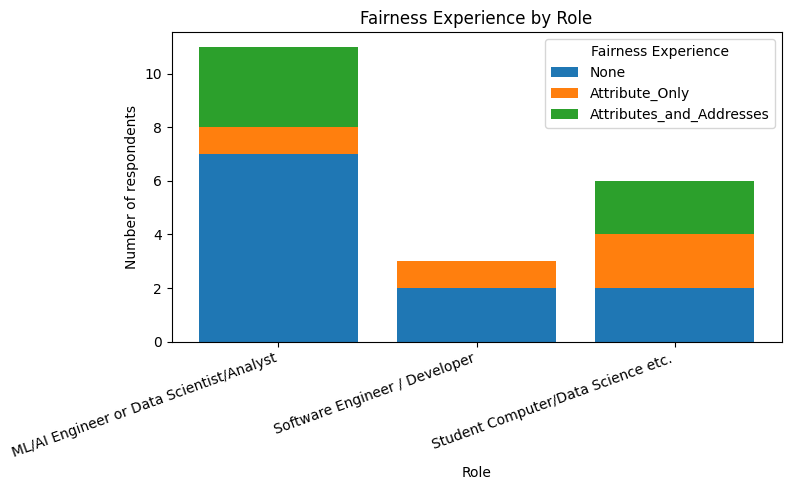

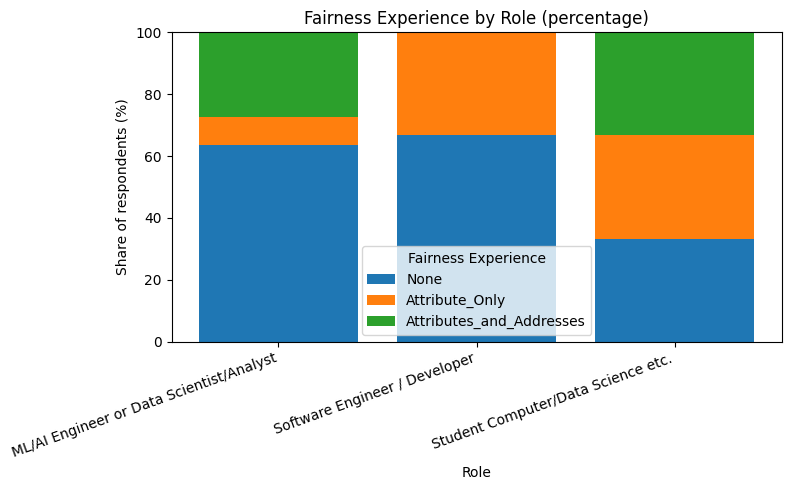

In [5]:

contingency_dynamic = pd.crosstab(df[role_col], df["Fairness_Experience"])
ordered_cols = ["None", "Attribute_Only", "Attributes_and_Addresses"]
contingency_dynamic = contingency_dynamic[[col for col in ordered_cols if col in contingency_dynamic.columns]]

# Plot nuemric
fig, ax = plt.subplots(figsize=(8, 5))
bottom = None
for exp_level in contingency_dynamic.columns:
    counts = contingency_dynamic[exp_level]
    ax.bar(
        contingency_dynamic.index,
        counts,
        bottom=bottom,
        label=exp_level
    )
    bottom = counts if bottom is None else bottom + counts

ax.set_xlabel("Role")
ax.set_ylabel("Number of respondents")
ax.set_title("Fairness Experience by Role")
ax.legend(title="Fairness Experience")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

contingency_pct = contingency_dynamic.div(contingency_dynamic.sum(axis=1), axis=0) * 100

# Plot percentage (normalized)
fig, ax = plt.subplots(figsize=(8, 5))
bottom = None
for exp_level in contingency_pct.columns:
    pct_values = contingency_pct[exp_level]
    ax.bar(contingency_pct.index,
           pct_values,
           bottom=bottom,
           label=exp_level)
    bottom = pct_values if bottom is None else bottom + pct_values

ax.set_xlabel("Role")
ax.set_ylabel("Share of respondents (%)")
ax.set_title("Fairness Experience by Role (percentage)")
ax.legend(title="Fairness Experience")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


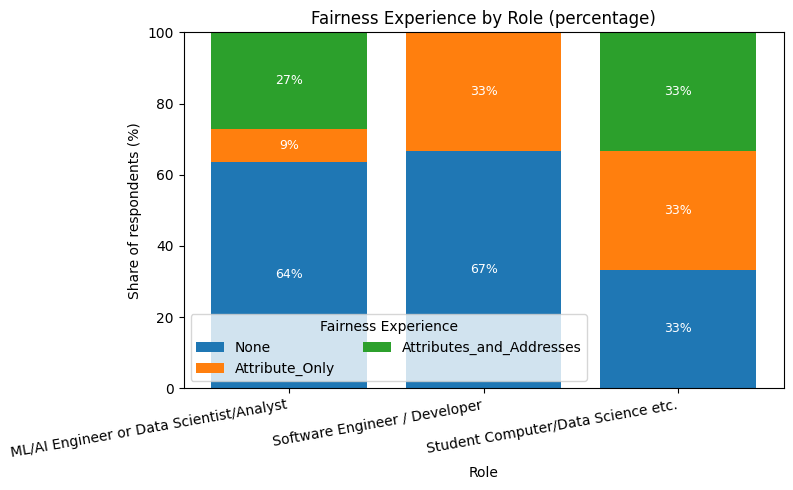

In [6]:
# normalized plot, add numbers, fix format
fig, ax = plt.subplots(figsize=(8, 5))
bottom = pd.Series([0] * len(contingency_pct), index=contingency_pct.index)

for exp_level in contingency_pct.columns:
    
    pct_values = contingency_pct[exp_level]
    bars = ax.bar(
        contingency_pct.index,
        pct_values,
        bottom=bottom,
        label=exp_level
    )
    # Add text labels
    for bar, pct in zip(bars, pct_values):
        if pct == 0:
            continue         
        ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        f"{pct:.0f}%",
        ha="center",
        va="center",
        fontsize=9,
        color="white"
        )
    bottom += pct_values     

# Axis / legend styling
ax.set_xlabel("Role")
ax.set_ylabel("Share of respondents (%)")
ax.set_title("Fairness Experience by Role (percentage)")
ax.set_ylim(0, 100)
ax.legend(title="Fairness Experience",
          loc="lower left",
          bbox_to_anchor=(0, 0.0),
          ncol=2) 

plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.show()

### Part 2: Conceptual Understanding

In [7]:
q6_col = [c for c in df.columns if c.startswith("Below is a list of fairness definitions")][0]

def split_q6(respondent_text: str) -> list[str]:
    """
    Split on commas that are NOT inside parentheses.
    """
    if pd.isna(respondent_text):
        return []
    # regex: split on commas not followed by any number of non-parentheses then a closing paren
    parts = re.split(r',(?![^\(]*\))', respondent_text)
    return [p.strip() for p in parts if p.strip()]

# ---------- Q6 ANALYSIS ----------
q6_raw = df[q6_col].dropna()
q6_tokens = [token for resp in q6_raw for token in split_q6(resp)]
q6_counts = Counter(q6_tokens)

q6_df = (pd.DataFrame({
            "Fairness Definition": list(q6_counts.keys()),
            "Count": list(q6_counts.values())
          })
          .assign(Percent=lambda d: (d["Count"] / n * 100).round(1))
          .sort_values("Count", ascending=False))


In [8]:
# Categorize each respondent
categories = []
for resp in df[q6_col]:
    tokens = split_q6(resp)
    has_knowledge = any(tok not in ["Not sure", "None of the above"] for tok in tokens)
    unsure_or_none = any(tok in ["Not sure", "None of the above"] for tok in tokens)
    if unsure_or_none and not has_knowledge:
        categories.append("Unsure / None only")
    elif has_knowledge:
        categories.append("Knew at least one definition")
    else:
        categories.append("No answer")

df['Q6_Category'] = categories

# Count categories
counts = df['Q6_Category'].value_counts().reset_index()
counts.columns = ['Category', 'Count']
counts['Percent'] = (counts['Count'] / len(df) * 100).round(1)
counts

,Category,Count,Percent
0,Unsure / None only,10,50.0
1,Knew at least one definition,10,50.0


In [9]:
# check if data scientist know more? 
# --- Count formal defs per respondent ---
def_count = []
for resp in df[q6_col]:
    tokens = split_q6(resp)
    formal_defs = [t for t in tokens
                   if t not in ("Not sure", "None of the above")]
    def_count.append(len(formal_defs))

df["Defs_Known"] = def_count    

# --- GROUP BY role (mean + SD) ---
grp = (df.groupby(role_col)["Defs_Known"]
         .agg(Count="size",
              Mean="mean",
              SD=lambda s: s.std(ddof=0))
         .round({"Mean": 2, "SD": 2}))

print("\nAverage number of definitions known, by role")
print(grp)


Average number of definitions known, by role
                                                Count  Mean    SD
Which option best describes your current role?                   
ML/AI Engineer or Data Scientist/Analyst           11  1.27  1.42
Software Engineer / Developer                       3  0.33  0.47
Student Computer/Data Science etc.                  6  0.83  1.07


In [10]:
# only inlude the ones that know sth
df_knowers = df[df["Defs_Known"] > 0].copy()

grp_knowers = (df_knowers.groupby(role_col)["Defs_Known"]
                 .agg(Count="size",
                      Mean="mean",
                      SD=lambda s: s.std(ddof=0))
                 .round({"Mean": 2, "SD": 2}))

print("\nAverage number of definitions (among respondents who knew ≥1), by role")
print(grp_knowers)


Average number of definitions (among respondents who knew ≥1), by role
                                                Count  Mean    SD
Which option best describes your current role?                   
ML/AI Engineer or Data Scientist/Analyst            6  2.33  1.11
Software Engineer / Developer                       1  1.00  0.00
Student Computer/Data Science etc.                  3  1.67  0.94


In [11]:
q6_df

,Fairness Definition,Count,Percent
0,Not sure,8,40.0
1,Calibration (predicted probabilities mean the ...,8,40.0
2,Equal Opportunity (equal true positive rates a...,5,25.0
3,Statistical Parity (equal probability of posit...,4,20.0
4,None of the above,4,20.0
5,Equalized Odds (equal false positive and false...,3,15.0


In [12]:
q7_col = [c for c in df.columns if "Some practitioners prioritize an outcome-based rule" in c][0]
# Count each selection
q7_raw = df[q7_col].dropna()

# Split responses (comma-separated) and flatten the list
all_choices = []
for response in q7_raw:
    parts = [x.strip() for x in str(response).split(',')]
    all_choices.extend(parts)

# Count occurrences
q7_counts = pd.Series(all_choices).value_counts().reset_index()
q7_counts.columns = ['Fairness Notion', 'Count']
q7_counts

,Fairness Notion,Count
0,Error-based,13
1,Outcome-based,4
2,Not sure,3


In [13]:
df_exploded = df.dropna(subset=[q7_col])
df_exploded[q7_col] = df_exploded[q7_col].str.split(',').apply(lambda x: [i.strip() for i in x])
df_exploded = df_exploded.explode(q7_col)

pd.crosstab(df_exploded[role_col], df_exploded[q7_col], normalize='index') * 100


"Some practitioners prioritize an outcome-based rule (e.g., 50 % of both men and women are classified ‘hired’). Others prioritize an error-based rule (e.g., If 70% of qualified men are hired, then 70% of qualified women should be too). Which approach would you prioritize in this scenario?",Error-based,Not sure,Outcome-based
Which option best describes your current role?,,,
ML/AI Engineer or Data Scientist/Analyst,72.727273,9.090909,18.181818
Software Engineer / Developer,33.333333,66.666667,0.000000
Student Computer/Data Science etc.,66.666667,0.000000,33.333333


In [14]:
q8_col = [c for c in df.columns if c.startswith("Imagine a model that satisfies formal fairness constraints")][0]
q8_counts = df[q8_col].value_counts(dropna=True).reset_index()
q8_counts.columns = ["Response", "Count"]
q8_counts["Percent"] = q8_counts["Count"] / len(df) * 100
q8_counts

,Response,Count,Percent
0,No — equal error rates are not enough if outco...,7,35.0
1,It depends on the use case,6,30.0
2,Yes — if the defined fairness constraints are ...,5,25.0
3,Not sure,2,10.0


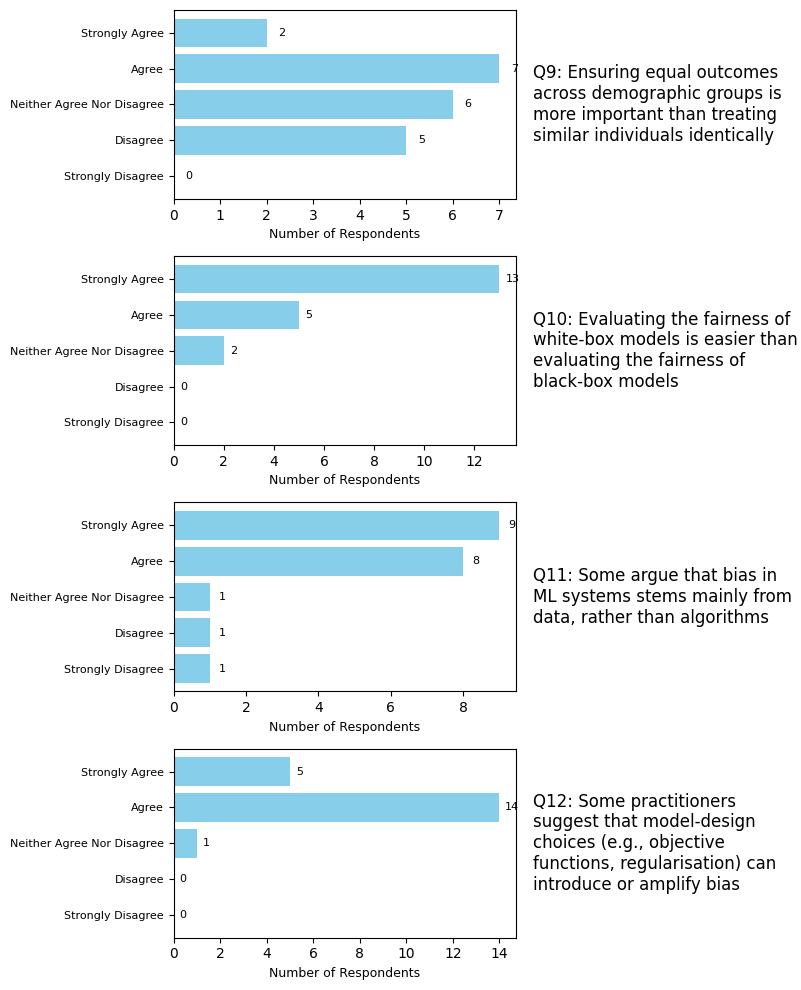

In [15]:
# Q9-Q12
numbered_questions = [
    ("Q9", "Ensuring equal outcomes across demographic groups is more important than treating similar individuals identically"),
    ("Q10", "Evaluating the fairness of white-box models is easier than evaluating the fairness of black-box models"),
    ("Q11", "Some argue that bias in ML systems stems mainly from data, rather than algorithms"),
    ("Q12", "Some practitioners suggest that model-design choices (e.g., objective functions, regularisation) can introduce or amplify bias"),
]

question_cols = [
    next(col for col in df.columns if q_text in col)
    for _, q_text in numbered_questions
]

# 4. Normalise Likert responses 
df[question_cols] = df[question_cols].apply(lambda c: c.str.strip().str.title())

likert_order = [
    "Strongly Disagree",
    "Disagree",
    "Neither Agree Nor Disagree",
    "Agree",
    "Strongly Agree",
]

# 5. Plot: two columns per row (bar plot | question text)
n = len(question_cols)
fig, axes = plt.subplots(
    nrows=n, ncols=2,
    figsize=(8, 2.5 * n),
    gridspec_kw={"width_ratios": [2, 1]},   
)

# Reduce whitespace between plot + text
plt.subplots_adjust(wspace=0.05)

for (q_num, q_text), col, (ax_plot, ax_text) in zip(numbered_questions, question_cols, axes):
    # --- bar chart (left)
    counts = df[col].value_counts().reindex(likert_order).fillna(0).astype(int)
    ax_plot.barh(likert_order, counts.values, color="skyblue")
    for y, v in enumerate(counts.values):
        ax_plot.text(v + 0.25, y, str(v), va="center", fontsize=8)

    ax_plot.set_xlim(left=0)
    ax_plot.set_xlabel("Number of Respondents", fontsize=9)
    ax_plot.tick_params(axis="y", labelsize=8)

    # --- question text (right)
    ax_text.axis("off")
    ax_text.text(
        0.0, 0.5,
        f"{q_num}: {q_text}",
        fontsize=12,
        va="center",
        ha="left",
        wrap=True,
        transform=ax_text.transAxes,
    )

plt.tight_layout()
plt.show()

### Part 3: Challenges to Fairness Implementation

Text(0.0, 0.5, 'Q13: Many practitioners report that fairness techniques can be difficult to implement in practice.')

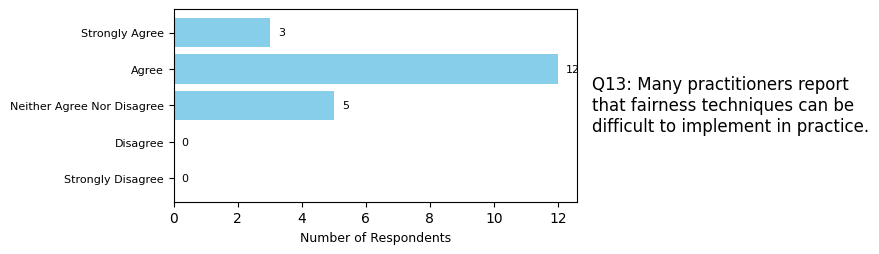

In [16]:
# Q13 likert 
# mirror Q9–Q12 plot format but only for Q13 
numbered_questions = [
    ("Q13", "Many practitioners report that fairness techniques can be difficult to implement in practice.")
]

question_cols = [
    next(col for col in df.columns if q_text in col)
    for _, q_text in numbered_questions
]

df[question_cols] = df[question_cols].apply(lambda c: c.str.strip().str.title())

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8, 2.5),
    gridspec_kw={"width_ratios": [2, 1]}
)

plt.subplots_adjust(wspace=0.05)

(q_num, q_text), col, (ax_plot, ax_text) = numbered_questions[0], question_cols[0], axes

# Bar chart
counts = df[col].value_counts().reindex(likert_order).fillna(0).astype(int)
ax_plot.barh(likert_order, counts.values, color="skyblue")
for y, v in enumerate(counts.values):
    ax_plot.text(v + 0.25, y, str(v), va="center", fontsize=8)

ax_plot.set_xlim(left=0)
ax_plot.set_xlabel("Number of Respondents", fontsize=9)
ax_plot.tick_params(axis="y", labelsize=8)

# Question text
ax_text.axis("off")
ax_text.text(
    0.0, 0.5,
    f"{q_num}: {q_text}",
    fontsize=12,
    va="center",
    ha="left",
    wrap=True,
    transform=ax_text.transAxes,
)

In [17]:
# Q21 
q21_col = [c for c in df.columns if "what makes it difficult" in c.lower()][0]
responses = df[q21_col].dropna().astype(str).str.strip()


In [18]:
responses.tolist()

['embedded bias in data due to the state of the world',
 'not enough knowledge about it',
 'Data quality and historical unfairness',
 'Data',
 'most data is biased/unfair',
 'biased data collection',
 'Applying fairness concepts in real-world ML systems is difficult due to biased data, complex models, and the need to balance fairness with accuracy, especially since most companies still need to prioritize profitability to stay competitive',
 "the world is biased und unfair, even when data is collected evenly-- can it ever be 'fair'?",
 'The definition of fairness is often context-dependent and shifting. Data limitations are nearly universal — biased, incomplete, or missing sensitive attributes. In production, it’s difficult to justify reductions in accuracy to improve fairness. Overarching question: should models compensate for an unfair world, or does that risk introducing new biases?',
 'I have no experience applying fairness, I only have experience in a productive environmen',
 'The 

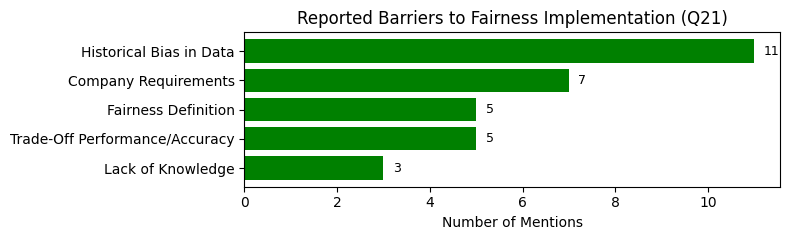

In [19]:
# grouped manually due to small scope
updated_counts = {
    "Historical Bias in Data": 11,
    "Trade‑Off Performance/Accuracy": 5,
    "Company Requirements": 7,
    "Lack of Knowledge": 3,
    "Fairness Definition": 5,
}

# sorts descending
sorted_items = sorted(updated_counts.items(), key=lambda kv: kv[1], reverse=False)
labels, values = zip(*sorted_items)

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.barh(labels, values, color="green")
ax.set_xlabel("Number of Mentions")
ax.set_title("Reported Barriers to Fairness Implementation (Q21)")
for y, v in enumerate(values):
    ax.text(v + 0.2, y, str(v), va="center", fontsize=9)
plt.tight_layout()


### Part 4: Implementation in Practice

Text(0.0, 0.5, 'Q14: Ensuring fairness in machine learning systems is a stated goal in my organization.')

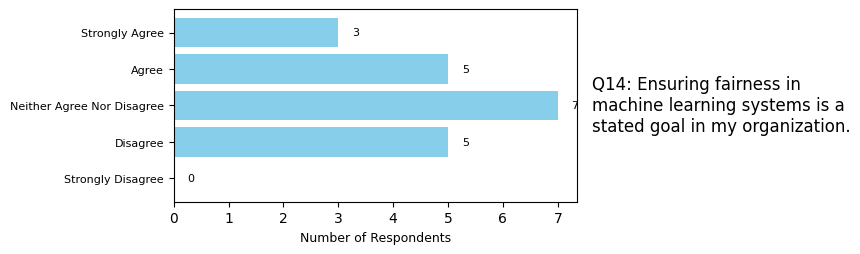

In [35]:
# Find the Q14 column
q14_col = [c for c in df.columns if "stated goal in my organization" in c.lower()][0]

numbered_questions = [
    ("Q14", "Ensuring fairness in machine learning systems is a stated goal in my organization.")
]

question_cols = [
    next(col for col in df.columns if q_text in col)
    for _, q_text in numbered_questions
]
# Normalize responses to title case
q14_responses = df[q14_col].dropna().astype(str).str.strip().str.title()

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8, 2.5),
    gridspec_kw={"width_ratios": [2, 1]}
)

plt.subplots_adjust(wspace=0.05)

(q_num, q_text), col, (ax_plot, ax_text) = numbered_questions[0], question_cols[0], axes

# Bar chart
counts = q14_responses.value_counts().reindex(likert_order).fillna(0).astype(int)
ax_plot.barh(likert_order, counts.values, color="skyblue")
for y, v in enumerate(counts.values):
    ax_plot.text(v + 0.25, y, str(v), va="center", fontsize=8)

ax_plot.set_xlim(left=0)
ax_plot.set_xlabel("Number of Respondents", fontsize=9)
ax_plot.tick_params(axis="y", labelsize=8)

# Question text
ax_text.axis("off")
ax_text.text(
    0.0, 0.5,
    f"{q_num}: {q_text}",
    fontsize=12,
    va="center",
    ha="left",
    wrap=True,
    transform=ax_text.transAxes,
)

In [21]:
## check q17, sounds a little contradictory to Q14...
q17_col = [c for c in df.columns if "have you used any fairness tools" in c.lower()][0]

q17_counts = df[q17_col].dropna().astype(str).str.strip().value_counts()
q17_counts


Have you used any fairness tools (e.g., AIF360, Fairlearn)?
No    20
Name: count, dtype: int64

In [22]:
# Q15 AND Q16, check counts
q15_col = [c for c in df.columns if "where in the ml pipeline do you believe fairness" in c.lower()][0]
q16_col = [c for c in df.columns if "where do fairness challenges most often emerge" in c.lower()][0]

q15_counts = df[q15_col].dropna().astype(str).str.strip().value_counts()
q16_counts = df[q16_col].dropna().astype(str).str.strip().value_counts()

q15_counts, q16_counts

(Where in the ML pipeline do you believe fairness should ideally be embedded? \nSelect the stage where embedding fairness would have the greatest impact.
 During data collection           18
 During model development          1
 In post-deployment monitoring     1
 Name: count, dtype: int64,
 Based on your experience, where do fairness challenges most often emerge?
 Data Collection                  10
 Model Design & Training           5
 Deployment & Use                  3
 Uncertain / varies by project     2
 Name: count, dtype: int64)

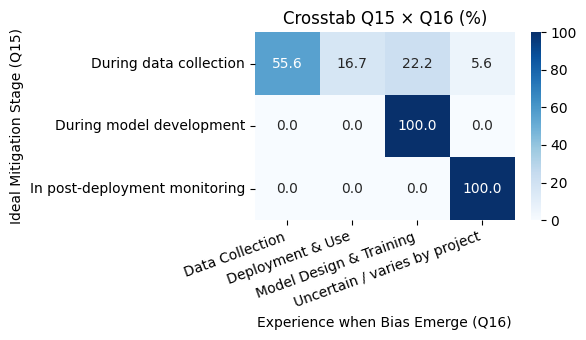

In [23]:
# check how experience and ideals cross
df[q15_col] = df[q15_col].str.strip()
df[q16_col] = df[q16_col].str.strip()

# Crosstab 
ct = pd.crosstab(df[q15_col], df[q16_col])
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100 # normalize

# Heat-map for a quick visual
plt.figure(figsize=(6, 3.5))
sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Experience when Bias Emerge (Q16)")
plt.ylabel("Ideal Mitigation Stage (Q15)")
plt.title("Crosstab Q15 × Q16 (%)")
plt.xticks(rotation=20, ha="right") 
plt.tight_layout()
plt.show()


In [24]:
ct

"Based on your experience, where do fairness challenges most often emerge?",Data Collection,Deployment & Use,Model Design & Training,Uncertain / varies by project
Where in the ML pipeline do you believe fairness should ideally be embedded? Select the stage where embedding fairness would have the greatest impact.,,,,
During data collection,10,3,4,1
During model development,0,0,1,0
In post-deployment monitoring,0,0,0,1


### Part 5: Trade-offs and Priorization 

In [25]:
# ---------- 2) Locate columns for Q18 and Q19 ----------
q18_col = next(c for c in df.columns if "Consider the following scenario:\nA company uses a machine learning model trained " in str(c))
q19_col = next(c for c in df.columns if "Consider the following scenario:\nA pretrial risk assessment model is used by judges" in str(c)) 

# ---------- 3) Define mapping dictionaries ----------
q18_map = {
    "Ensure both false positive and false negative rates are equal across groups": "Equalized Odds",
    "Ensure equal high-income predictions across genders": "Statistical Parity Difference",
    "Reduce unjustified group-level disparities, regardless of model intent": "Disparate Impact",
    "Ensure that qualified individuals of all genders are treated equally": "Equal Opportunity",
    "Optimize the model’s overall predictive performance over fairness interventions": "Accuracy",
}

q19_map = {
    "Ensure both false positive and true positive rates are equal between racial groups": "Equalized Odds",
    "Equalize the rate of being labeled “low risk” between racial groups, regardless of outcome": "Statistical Parity Difference",
    "Minimize disproportionate harm to any racial group, even if decisions appear neutral": "Disparate Impact",
    "Align only the true positive rates (those who actually reoffend) across groups": "Equal Opportunity",
    "Optimize the model’s overall predictive performance over fairness interventions": "Accuracy",
}

# ---------- 4) Apply mapping ----------
df["Q18_metric"] = df[q18_col].map(q18_map)
df["Q19_metric"] = df[q19_col].map(q19_map)

# ---------- 5) Count frequencies ----------
q18_counts = df["Q18_metric"].value_counts(dropna=False)
q19_counts = df["Q19_metric"].value_counts(dropna=False)

q18_counts, q19_counts

(Q18_metric
 Equal Opportunity    12
 Equalized Odds        6
 NaN                   1
 Disparate Impact      1
 Name: count, dtype: int64,
 Q19_metric
 Equalized Odds       15
 Accuracy              2
 Disparate Impact      1
 NaN                   1
 Equal Opportunity     1
 Name: count, dtype: int64)

In [26]:
# retrieve other:___ Q18
unmapped_q18 = df.loc[df["Q18_metric"].isna(), q18_col].unique()
print("Q18:\n", unmapped_q18)

# retrieve other:___ Q19
unmapped_q19 = df.loc[df["Q19_metric"].isna(), q19_col].unique()
print("Q19:\n", unmapped_q19)

Q18:
 ['Use another approach than historical income values']
Q19:
 ['Remove racial group as a independent variable or add a lower coefficient']


In [27]:
# Label the text for plot
df["Q18_metric"].fillna("Other", inplace=True)
df["Q19_metric"].fillna("Other", inplace=True)

# Re-count
q18_counts = df["Q18_metric"].value_counts()
q19_counts = df["Q19_metric"].value_counts()

q18_counts, q19_counts

(Q18_metric
 Equal Opportunity    12
 Equalized Odds        6
 Other                 1
 Disparate Impact      1
 Name: count, dtype: int64,
 Q19_metric
 Equalized Odds       15
 Accuracy              2
 Disparate Impact      1
 Other                 1
 Equal Opportunity     1
 Name: count, dtype: int64)

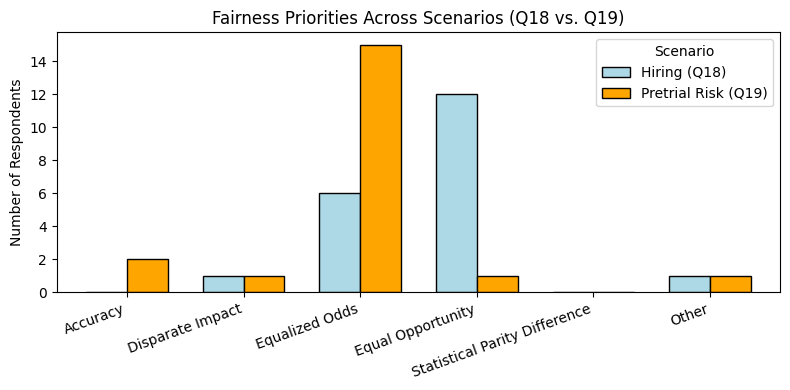

In [28]:
combined = pd.DataFrame({
    "Hiring (Q18)": q18_counts,
    "Pretrial Risk (Q19)": q19_counts
}).fillna(0).astype(int)

# Sort categories for consistency
combined = combined.reindex([
    "Accuracy",
    "Disparate Impact",
    "Equalized Odds",
    "Equal Opportunity",
    "Statistical Parity Difference",
    "Other"
])

# Plot
ax = combined.plot(
    kind="bar",
    figsize=(8, 4),
    width=0.7,
    color=["lightblue", "orange"],
    edgecolor="black"
)

ax.set_ylabel("Number of Respondents")
ax.set_title("Fairness Priorities Across Scenarios (Q18 vs. Q19)")
ax.set_xticklabels(combined.index, rotation=20, ha="right")
ax.legend(title="Scenario")
plt.tight_layout()
plt.show()


In [29]:
# Q20 
q20_col = next(c for c in df.columns if c.startswith("When fairness interventions reduce predictive accuracy"))

# Step 2: Show unique responses to Q20 to understand the structure
df[q20_col].value_counts(dropna=False)
    

When fairness interventions reduce predictive accuracy, which goal do you rate as more important?
Maximizing fairness, even at some cost to accuracy    9
Maximizing accuracy, even if fairness is reduced      7
Not sure                                              4
Name: count, dtype: int64

In [30]:
role_col = next(c for c in df.columns if c.startswith("Which option best describes your current role"))
q20_col  = next(c for c in df.columns if c.startswith("When fairness interventions reduce predictive accuracy"))

df["Q20_choice"] = (
    df[q20_col].astype(str).str.strip().replace({
        "Maximizing fairness, even at some cost to accuracy": "Fairness",
        "Maximizing accuracy, even if fairness is reduced": "Accuracy"
    }).fillna("Not sure")
)

ct_raw = pd.crosstab(df[role_col], df["Q20_choice"])
ct_pct = ct_raw.div(ct_raw.sum(axis=1), axis=0) * 100

# Reindex to enforce consistent category order
for col in ["Accuracy", "Fairness", "Not sure"]:
    if col not in ct_pct.columns:
        ct_pct[col] = 0.0  
ct_pct = ct_pct[["Accuracy", "Fairness", "Not sure"]]  

new_order = [
    "ML/AI Engineer or Data Scientist/Analyst",
    "Software Engineer / Developer",
    "Student Computer/Data Science etc."
]
ct_pct = ct_pct.reindex(new_order)
labels = new_order 
y_pos = np.arange(len(labels))

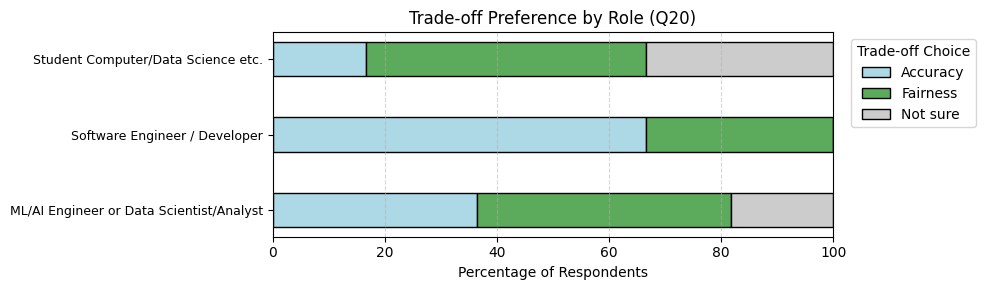

In [31]:
labels = ct_pct.index.tolist()
categories = ["Accuracy", "Fairness", "Not sure"]
colors = ["lightblue", "#5cab5c", "#cccccc"]

y_pos = np.arange(len(labels))
bar_h  = 0.45                     

#  plot
fig, ax = plt.subplots(figsize=(10, 3))  
left = np.zeros(len(labels))

for cat, col in zip(categories, colors):
    ax.barh(    
        y_pos,
        ct_pct[cat],
        left=left,
        height=bar_h,
        color=col,
        edgecolor="black",
        label=cat
    )
    left += ct_pct[cat]

# 3) cosmetics
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel("Percentage of Respondents")
ax.set_title("Trade-off Preference by Role (Q20)")
ax.set_xlim(0, 100)
ax.grid(axis="x", linestyle="--", alpha=0.5)
ax.legend(title="Trade-off Choice", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [32]:
ct_pct

Q20_choice,Accuracy,Fairness,Not sure
Which option best describes your current role?,,,
ML/AI Engineer or Data Scientist/Analyst,36.363636,45.454545,18.181818
Software Engineer / Developer,66.666667,33.333333,0.000000
Student Computer/Data Science etc.,16.666667,50.000000,33.333333
